In [1]:
# import necessary python libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import contextily
pd.set_option("display.max_columns", 150)
import datetime
import seaborn as sns
import requests
import json
import urllib

## 1. Import geocoded deeds

Import geocoded deeds for records between 2000-2021

In [2]:
deeds00_21_geo_fromcsv = pd.read_csv("data/SR1A_deeds/deeds00_21_geocoded.csv",low_memory=False)

deeds00_21 = gpd.GeoDataFrame(deeds00_21_geo_fromcsv, 
    geometry=gpd.points_from_xy(deeds00_21_geo_fromcsv.longitude_result,deeds00_21_geo_fromcsv.latitude_result))


deeds00_21 = deeds00_21.set_crs('epsg:4326').to_crs('epsg:3424')

In [3]:
deeds00_21.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Municipality', 'Grantor's Name (Seller)',
       'Grantor's Mailing Address', 'Grantor's City/State/Zip',
       'Grantee's Name (Buyer)', 'Grantee's Mailing Address',
       'Grantee's City/State/Zip', 'Property Location', 'Block', 'Lot', 'Qual',
       'Property Class', 'Land Assmnt', 'Building Assmnt', 'Total Assmnt',
       'Recorded Date', 'Deed Date', 'Book', 'Page', 'Sale Price', 'NU Code',
       'Sq. Ft.', 'Cl. 4 Use', 'SR1A #', 'Yr. Built', 'StyDesc', 'Style',
       'deed_date_cl', 'deed_date_dt', 'year', 'city', 'state', 'zip',
       'RecordID', 'latitude_result', 'longitude_result', 'geometry'],
      dtype='object')

In [4]:
# cleaning column nam
deeds00_21 = deeds00_21.rename(columns={"Grantor's Name (Seller)":"grantor",
        "Grantor's Mailing Address":"grantor_address",
        "Grantor's City/State/Zip":"grantor_city_st_zip",
        "Grantee's Name (Buyer)":"grantee",
        "Grantee's Mailing Address":"grantee_address",
        "Grantee's City/State/Zip":"grantee_city_st_zip"})
deeds00_21 = deeds00_21.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)    

## 2. Identify likely investor purchases
First tag all grantees with corporate entity names. Then find all investors who purchased more than 2 properties in any one year span.   

### 2A. Identifying Deeds with likely investors as the grantee based on grantee name
First tag all investor named entities   
  - LLC
  - LP
  - LIMITED PARTNERSHIP
  - CORP
  - CORPORATION
  - INC
  - COMPANY
  - LIMITED PARTNE
  - L P
  - L L C
  - PARTNERSHIP
  - LTD
  - TRUST 
    


In [5]:
# selecting investors by grantee name
inv = deeds00_21['grantee'].str.contains(
    'LLC|LP|LIMITED PARTNERSHIP|CORP|CORPORATION|INC|COMPANY|LIMITED PARTNE|L P|L L C|PARTNERSHIP|LTD|TRUST|BANK|PROPERT|MORTGAGE|LOAN|NEW JERSEY|NATIONAL|DEVEL|ASSOC|FUND|REALTY|FINANCIAL|MANAGE|REAL ESTATE|HOLDIN|HOLDING|LIMITED'
    ,regex=True)
pub = deeds00_21['grantee'].str.contains(
    'CITY OF NEWARK|NEWARK,CITY OF|SECRETARY|AUTHORITY|HOUSING & URBAN DEV|STATE OF|DEPT|DEPARTMENT|NJ SCHOOLS', 
    regex=True)
# converting investors series to dataframe
inv = inv.to_frame()
pub = pub.to_frame()
# merging with deeds
deeds_inv = deeds00_21.merge(
    inv, left_index=True, right_index = True)
deeds_inv = deeds_inv.merge(pub, left_index=True, right_index=True)
deeds_inv = deeds_inv.dropna(subset=['grantee_x'])
# creating a count column to allow grouping and count 
# for investor and owner by year 
deeds_inv['inv'] = deeds_inv['grantee_y'].apply(lambda x: 1 if x == True else 0)
deeds_inv['occ'] = deeds_inv['grantee_y'].apply(lambda x: 1 if x == False else 0)
deeds_inv['pub'] = deeds_inv['grantee'].apply(lambda x: 1 if x == True else 0)

# # dropping duplicate object ids from the dataset
# deeds_inv = deeds_inv.drop_duplicates(subset="SR1A #")

In [6]:
deeds_inv[deeds_inv['pub']==1]

,Municipality,grantor,grantor_address,grantor_city_st_zip,grantee_x,grantee_address,grantee_city_st_zip,Property Location,Block,Lot,Qual,Property Class,Land Assmnt,Building Assmnt,Total Assmnt,Recorded Date,Deed Date,Book,Page,Sale Price,NU Code,Sq. Ft.,Cl. 4 Use,SR1A #,Yr. Built,StyDesc,Style,deed_date_cl,deed_date_dt,year,city,state,zip,RecordID,latitude_result,longitude_result,geometry,grantee_y,grantee,inv,occ,pub
609,714,SHERIFF ARMANDO FONTOURA,ESSEX COUNTY COURT HOUSE,"NEWARK, NJ 00000",SECRETARY OF VETERANS AFFAIRS,3401 W END AVE #760W,"NASHVILLE, TN 00000",16 CLIFF HILL PL,4125.01,11.00,NaN,2,22000,118300,96300,3/20/20,1/28/20,20200,31112,100.0,12.0,1116.0,0.0,5693032.0,1957.0,NaN,NaN,01/28/20,2020-01-28,2020.0,Newark,NJ,NaN,5693032.0,40.740440,-74.234720,POINT (565630.242 694748.532),False,True,0,1,1
2351,714,"BANK OF AMERICA, N.A.",7105 CORPORATE DRIVE,"PLANO, TX 00000",SECRETARY OF HOUSING,2401 NW 23RD STREET #1D,"OKLAHOMA CITY, OK 00000",181 GARSIDE ST,518.00,60.00,NaN,2,17800,94600,76800,10/16/19,6/15/19,20190,98221,1.0,15.0,1350.0,0.0,5686777.0,1902.0,NaN,NaN,06/15/19,2019-06-15,2019.0,Newark,NJ,NaN,5686777.0,40.757530,-74.174484,POINT (582297.731 701030.605),False,True,0,1,1
4437,714,SHERIFF ARMANDO FONTOURA,ESSEX COUNTY COURT HOUSE,"NEWARK, NJ 00000",HOUSING & URBAN DEVELOPMENT,2401 NW 23RD ST #1D,"OKLAHOMA CITY, OK 00000",360 N 6TH ST,1935.00,3.00,NaN,2,27500,132700,105200,3/19/19,7/25/16,20190,25236,100.0,12.0,2096.0,0.0,5405002.0,1917.0,NaN,NaN,07/25/16,2016-07-25,2016.0,Newark,NJ,NaN,5405002.0,40.761147,-74.185980,POINT (579108.525 702336.582),True,True,1,0,1
4806,714,"MORTGAGE RESEARCH CENTER, LLC.",425 PHILLIPS BOULEVARD,"EWING, NJ 00000",SECRETARY OF VETERANS AFFAIRS,1240 EAST NINTH STREET,"CLEVELAND, OH 00000",196 BROOKDALE AVE,4075.00,5.00,NaN,2,16900,100700,83800,2/8/19,12/19/18,20190,11992,1.0,15.0,1194.0,0.0,5403176.0,1924.0,NaN,NaN,12/19/18,2018-12-19,2018.0,Newark,NJ,NaN,5403176.0,40.739586,-74.229416,POINT (567100.869 694441.914),False,True,0,1,1
4975,714,SHERIFF ARMANDO FONTOURA,ESSEX COUNTY COURT HOUSE,"NEWARK, NJ 00000",HOUSING & URBAN DEVELOPMENT,2401 NW 23RD STREET #1D,"OKLAHOMA CITY, OK 00000",67 HUNTINGTON TER,3608.00,7.00,NaN,2,27500,152900,125400,1/28/19,9/23/16,20190,7933,100.0,15.0,2156.0,0.0,5402611.0,1925.0,NaN,NaN,09/23/16,2016-09-23,2016.0,Newark,NJ,NaN,5402611.0,40.715160,-74.209236,POINT (572722.045 685561.522),True,True,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66891,714,"FONTOURA, ARMANDO B.-SHERIFF",ESSEX COUNTY COURT HOUSE,"NEWARK, NJ 00000",DEPT. OF VETERANS AFFAIRS,20 WASHINGTON PL.,"NEWARK, NJ 00000",851- S. 16TH ST.,3012.00,9.00,NaN,2,800,3000,3800,3/22/00,3/2/00,5683,530,100.0,12.0,0.0,NaN,5751857.0,0.0,NaN,NaN,03/02/00,2000-03-02,2000.0,Newark,NJ,NaN,5751857.0,40.725899,-74.212229,POINT (571879.577 689470.955),False,True,0,1,1
66897,714,"FONTOURA, ARMANDO B.-SHERIFF",ESSEX COUNTY COURT HOUSE,"NEWARK, NJ 00000",SECRETARY OF HOUSING & URBAN DEVEL.,451 7TH ST.,WASHINGTON D.C. 00000,69-71 BOYLAN ST.,4063.00,98.00,NaN,2,2200,8800,11000,3/21/00,3/8/00,5682,919,0.0,12.0,0.0,NaN,5751816.0,0.0,NaN,NaN,03/08/00,2000-03-08,2000.0,Newark,NJ,NaN,5751816.0,40.743890,-74.226730,POINT (567840.246 696012.154),True,True,1,0,1
66946,714,"FONTOURA, ARMANDO B.-SHERIFF",ESSEX COUNTY COURT HOUSE,"NEWARK, NJ 00000",SECRETARY OF HOUSING & URBAN DEVEL.,451 7TH ST.,WASHINGTON D.C. 00000,61-63 ISABELLA AVE.,4035.00,55.00,NaN,2,3900,6600,10500,3/14/00,2/29/00,5681,382,0.0,15.0,0.0,NaN,5751380.0,0.0,NaN,NaN,02/29/00,2000-02-29,2000.0,Newark,NJ,NaN,5751380.0,40.743076,-74.220560,POINT (569550.727 695721.006),True,True,1,0,1
67230,714,"FONTOURA, ARMANDO B.-SHERIFF",ESSEX COUNTY COURT HOUSE,"NEWARK, NJ 00000",SECRETARY OF HOUSING & URBAN DEVEL.,1 NEWARK CTR.,"NEWARK, NJ 00000",243-245 S. SEVENTH ST.,1780.00,25.00,NaN,2,2800,10000,12800,2/7/00,1/14/00,5673,113,100.0,12

In [60]:
deeds_inv.shape

(67341, 42)

In [7]:
deeds_inv[deeds_inv['grantee']==True]

,Municipality,grantor,grantor_address,grantor_city_st_zip,grantee_x,grantee_address,grantee_city_st_zip,Property Location,Block,Lot,Qual,Property Class,Land Assmnt,Building Assmnt,Total Assmnt,Recorded Date,Deed Date,Book,Page,Sale Price,NU Code,Sq. Ft.,Cl. 4 Use,SR1A #,Yr. Built,StyDesc,Style,deed_date_cl,deed_date_dt,year,city,state,zip,RecordID,latitude_result,longitude_result,geometry,grantee_y,grantee,inv,occ,pub
609,714,SHERIFF ARMANDO FONTOURA,ESSEX COUNTY COURT HOUSE,"NEWARK, NJ 00000",SECRETARY OF VETERANS AFFAIRS,3401 W END AVE #760W,"NASHVILLE, TN 00000",16 CLIFF HILL PL,4125.01,11.00,NaN,2,22000,118300,96300,3/20/20,1/28/20,20200,31112,100.0,12.0,1116.0,0.0,5693032.0,1957.0,NaN,NaN,01/28/20,2020-01-28,2020.0,Newark,NJ,NaN,5693032.0,40.740440,-74.234720,POINT (565630.242 694748.532),False,True,0,1,1
2351,714,"BANK OF AMERICA, N.A.",7105 CORPORATE DRIVE,"PLANO, TX 00000",SECRETARY OF HOUSING,2401 NW 23RD STREET #1D,"OKLAHOMA CITY, OK 00000",181 GARSIDE ST,518.00,60.00,NaN,2,17800,94600,76800,10/16/19,6/15/19,20190,98221,1.0,15.0,1350.0,0.0,5686777.0,1902.0,NaN,NaN,06/15/19,2019-06-15,2019.0,Newark,NJ,NaN,5686777.0,40.757530,-74.174484,POINT (582297.731 701030.605),False,True,0,1,1
4437,714,SHERIFF ARMANDO FONTOURA,ESSEX COUNTY COURT HOUSE,"NEWARK, NJ 00000",HOUSING & URBAN DEVELOPMENT,2401 NW 23RD ST #1D,"OKLAHOMA CITY, OK 00000",360 N 6TH ST,1935.00,3.00,NaN,2,27500,132700,105200,3/19/19,7/25/16,20190,25236,100.0,12.0,2096.0,0.0,5405002.0,1917.0,NaN,NaN,07/25/16,2016-07-25,2016.0,Newark,NJ,NaN,5405002.0,40.761147,-74.185980,POINT (579108.525 702336.582),True,True,1,0,1
4806,714,"MORTGAGE RESEARCH CENTER, LLC.",425 PHILLIPS BOULEVARD,"EWING, NJ 00000",SECRETARY OF VETERANS AFFAIRS,1240 EAST NINTH STREET,"CLEVELAND, OH 00000",196 BROOKDALE AVE,4075.00,5.00,NaN,2,16900,100700,83800,2/8/19,12/19/18,20190,11992,1.0,15.0,1194.0,0.0,5403176.0,1924.0,NaN,NaN,12/19/18,2018-12-19,2018.0,Newark,NJ,NaN,5403176.0,40.739586,-74.229416,POINT (567100.869 694441.914),False,True,0,1,1
4975,714,SHERIFF ARMANDO FONTOURA,ESSEX COUNTY COURT HOUSE,"NEWARK, NJ 00000",HOUSING & URBAN DEVELOPMENT,2401 NW 23RD STREET #1D,"OKLAHOMA CITY, OK 00000",67 HUNTINGTON TER,3608.00,7.00,NaN,2,27500,152900,125400,1/28/19,9/23/16,20190,7933,100.0,15.0,2156.0,0.0,5402611.0,1925.0,NaN,NaN,09/23/16,2016-09-23,2016.0,Newark,NJ,NaN,5402611.0,40.715160,-74.209236,POINT (572722.045 685561.522),True,True,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66891,714,"FONTOURA, ARMANDO B.-SHERIFF",ESSEX COUNTY COURT HOUSE,"NEWARK, NJ 00000",DEPT. OF VETERANS AFFAIRS,20 WASHINGTON PL.,"NEWARK, NJ 00000",851- S. 16TH ST.,3012.00,9.00,NaN,2,800,3000,3800,3/22/00,3/2/00,5683,530,100.0,12.0,0.0,NaN,5751857.0,0.0,NaN,NaN,03/02/00,2000-03-02,2000.0,Newark,NJ,NaN,5751857.0,40.725899,-74.212229,POINT (571879.577 689470.955),False,True,0,1,1
66897,714,"FONTOURA, ARMANDO B.-SHERIFF",ESSEX COUNTY COURT HOUSE,"NEWARK, NJ 00000",SECRETARY OF HOUSING & URBAN DEVEL.,451 7TH ST.,WASHINGTON D.C. 00000,69-71 BOYLAN ST.,4063.00,98.00,NaN,2,2200,8800,11000,3/21/00,3/8/00,5682,919,0.0,12.0,0.0,NaN,5751816.0,0.0,NaN,NaN,03/08/00,2000-03-08,2000.0,Newark,NJ,NaN,5751816.0,40.743890,-74.226730,POINT (567840.246 696012.154),True,True,1,0,1
66946,714,"FONTOURA, ARMANDO B.-SHERIFF",ESSEX COUNTY COURT HOUSE,"NEWARK, NJ 00000",SECRETARY OF HOUSING & URBAN DEVEL.,451 7TH ST.,WASHINGTON D.C. 00000,61-63 ISABELLA AVE.,4035.00,55.00,NaN,2,3900,6600,10500,3/14/00,2/29/00,5681,382,0.0,15.0,0.0,NaN,5751380.0,0.0,NaN,NaN,02/29/00,2000-02-29,2000.0,Newark,NJ,NaN,5751380.0,40.743076,-74.220560,POINT (569550.727 695721.006),True,True,1,0,1
67230,714,"FONTOURA, ARMANDO B.-SHERIFF",ESSEX COUNTY COURT HOUSE,"NEWARK, NJ 00000",SECRETARY OF HOUSING & URBAN DEVEL.,1 NEWARK CTR.,"NEWARK, NJ 00000",243-245 S. SEVENTH ST.,1780.00,25.00,NaN,2,2800,10000,12800,2/7/00,1/14/00,5673,113,100.0,12

In [8]:
deeds_inv.shape[0]

67341

### 3. Classifying investor purchases by multiple purchasers
Identifying grantees who purchased more than 2 properties in any one year period from the full set of non-investor classified deeds:

In [9]:
# finding multiple purchasers from the full set of non-investor classified deeds
# selecting from just the non llc llp deeds
occ = deeds_inv.loc[deeds_inv['occ']==1].copy()

In [10]:
# getting all deeds from purchasers who are associated with more than one deed
multiple_purchasers = occ.groupby(
    "grantee_x").filter(lambda s: s['SR1A #'].count()>=2)


In [11]:
# converting date to datetime format
multiple_purchasers['deed_date_dt'] = pd.to_datetime(multiple_purchasers['deed_date_cl'], format='%m/%d/%y')

In [12]:
multiple_purchasers.columns

Index(['Municipality', 'grantor', 'grantor_address', 'grantor_city_st_zip',
       'grantee_x', 'grantee_address', 'grantee_city_st_zip',
       'Property Location', 'Block', 'Lot', 'Qual', 'Property Class',
       'Land Assmnt', 'Building Assmnt', 'Total Assmnt', 'Recorded Date',
       'Deed Date', 'Book', 'Page', 'Sale Price', 'NU Code', 'Sq. Ft.',
       'Cl. 4 Use', 'SR1A #', 'Yr. Built', 'StyDesc', 'Style', 'deed_date_cl',
       'deed_date_dt', 'year', 'city', 'state', 'zip', 'RecordID',
       'latitude_result', 'longitude_result', 'geometry', 'grantee_y',
       'grantee', 'inv', 'occ', 'pub'],
      dtype='object')

In [13]:
columns_multi = ['SR1A #','grantor','grantee_x',
                 'deed_date_dt','Property Location']
multiple_purchase_simple = multiple_purchasers[columns_multi].copy()


In [14]:

multiple_purchase_simple[
    'elapsed'] = multiple_purchase_simple.sort_values(
    ['grantee_x','deed_date_dt']).groupby(
    'grantee_x')['deed_date_dt'].diff()

# converting timedelta column to an int type 
# to make it possible to filter below
multiple_purchase_simple[
    'elapsed_days'] = multiple_purchase_simple[
    'elapsed'].dt.days


In [15]:
# filtering for deeds from grantees who purchased two properties within 1 year of each other
multiple_purchase_simple = multiple_purchase_simple.groupby('grantee_x').filter(
    lambda x: x['elapsed_days'].min() <= 365)
multiple_purchase_simple['multi_invest'] = 1

## 4. merging multiple purchase investors back with full set of deeds

Compiling a comprehensive classification of investor purchases 

In [16]:
deeds_multi = deeds_inv.merge(
    multiple_purchase_simple, left_on="SR1A #", right_on="SR1A #",how="left")


In [17]:
deeds_multi["investor_all"] = deeds_multi['inv'] + deeds_multi["multi_invest"].fillna(0)
deeds_multi['owner_occup'] = deeds_multi['investor_all'].apply(lambda x: 0 if x == 1 else 1)

In [18]:
deeds_multi.columns

Index(['Municipality', 'grantor_x', 'grantor_address', 'grantor_city_st_zip',
       'grantee_x_x', 'grantee_address', 'grantee_city_st_zip',
       'Property Location_x', 'Block', 'Lot', 'Qual', 'Property Class',
       'Land Assmnt', 'Building Assmnt', 'Total Assmnt', 'Recorded Date',
       'Deed Date', 'Book', 'Page', 'Sale Price', 'NU Code', 'Sq. Ft.',
       'Cl. 4 Use', 'SR1A #', 'Yr. Built', 'StyDesc', 'Style', 'deed_date_cl',
       'deed_date_dt_x', 'year', 'city', 'state', 'zip', 'RecordID',
       'latitude_result', 'longitude_result', 'geometry', 'grantee_y',
       'grantee', 'inv', 'occ', 'pub', 'grantor_y', 'grantee_x_y',
       'deed_date_dt_y', 'Property Location_y', 'elapsed', 'elapsed_days',
       'multi_invest', 'investor_all', 'owner_occup'],
      dtype='object')

In [35]:
# Saving classified deeds to speed up future processing time 
deeds_for_save = deeds_multi.copy()
deeds_for_save['elapsed'] = deeds_for_save['elapsed'].fillna(pd.Timedelta('999 days'))
# deeds_for_save['elapsed'] = deeds_for_save['elapsed'].dt.days.astype('int16')
# deeds_for_save['display_date'] = deeds_for_save['display_date_y'].astype(str)


In [51]:
# filter out for arms length sales based on sale price
deeds_for_save = deeds_for_save[deeds_for_save['Sale Price']>100]

# filter for arms length sales by grantor/grantee address matching
deeds_for_save = deeds_for_save[deeds_for_save['grantee_address']!=deeds_for_save['grantor_address']]

In [52]:
deeds_for_save.shape

(35941, 51)

In [53]:
# saving final list of deeds

deeds_for_save.to_csv("data/SR1A_deeds/deeds_00_21_classified.csv")

## 5. visualize deeds over time

In [54]:
deeds = pd.read_csv("data/SR1A_deeds/deeds_00_21_classified.csv", low_memory=False)

In [55]:
deeds

(35941, 52)

In [56]:
deeds['count_field'] = 1
# deeds_classified['year'] = deeds_classified['sort_year_x'].astype(str)
deeds.head()

,Unnamed: 0,Municipality,grantor_x,grantor_address,grantor_city_st_zip,grantee_x_x,grantee_address,grantee_city_st_zip,Property Location_x,Block,Lot,Qual,Property Class,Land Assmnt,Building Assmnt,Total Assmnt,Recorded Date,Deed Date,Book,Page,Sale Price,NU Code,Sq. Ft.,Cl. 4 Use,SR1A #,Yr. Built,StyDesc,Style,deed_date_cl,deed_date_dt_x,year,city,state,zip,RecordID,latitude_result,longitude_result,geometry,grantee_y,grantee,inv,occ,pub,grantor_y,grantee_x_y,deed_date_dt_y,Property Location_y,elapsed,elapsed_days,multi_invest,investor_all,owner_occup,count_field
0,0,714,"CAMPOS, FATIMA J",428 WASHINGTON AVE,"CLIFFSIDE PARK, NJ 00000","RYBRM HOLDINGS LLC,",198 CENTRAL AVE,"EAST ORANGE, NJ 00000",269 LAKE ST,540.0,43.0,NaN,2,21300,121100,99800,6/30/20,6/15/20,20200,60066,200000.0,26.0,1603.0,0.0,5696854.0,1902.0,NaN,NaN,06/15/20,2020-06-15,2020.0,Newark,NJ,NaN,5696854.0,40.760210,-74.179184,POINT (580992.187359745 702002.124279135),True,False,1,0,0,NaN,NaN,NaN,NaN,999 days,NaN,NaN,1.0,0,1
1,1,714,"92 TUXEDO LLC,",13 MUNICIPAL PLZ #629,"BLOOMFIELD, NJ 00000","AGOSTO, STEPHEN F & WIGGIN, MATTHEW",92-94 TUXEDO PKWY,"NEWARK, NJ 00000",92-94 TUXEDO PKWY,4266.0,32.0,NaN,2,29400,138100,108700,6/30/20,5/18/20,20200,60247,285000.0,7.0,1582.0,0.0,5696855.0,1929.0,NaN,NaN,05/18/20,2020-05-18,2020.0,Newark,NJ,NaN,5696855.0,40.737785,-74.243770,POINT (563125.4362055603 693773.8672076497),False,False,0,1,0,NaN,NaN,NaN,NaN,999 days,NaN,NaN,0.0,1,1
2,2,714,"PAULINO, JOSE M & TOMMY E",940 MADISON AVE,"PATERSON, NJ 00000","LIZARDO-SEQUENCIA, JAIME",490-492 SUMMER AVE,"NEWARK, NJ 00000",490-492 SUMMER AVE,625.0,41.0,NaN,2,35200,199100,163900,6/29/20,6/18/20,20200,59815,400000.0,7.0,2942.0,0.0,5696851.0,1908.0,NaN,NaN,06/18/20,2020-06-18,2020.0,Newark,NJ,NaN,5696851.0,40.768337,-74.166880,POINT (584389.2136115041 704975.4918734678),False,False,0,1,0,NaN,NaN,NaN,NaN,999 days,NaN,NaN,0.0,1,1
3,3,714,CARRINGTON MORTGAGE SERVICES LLC,1600 S DOUGLASS RD #130A,"ANAHEIM, CA 00000",684 S 20TH STREET LLC,684 S 20TH ST,"NEWARK, NJ 00000",684 S 20TH ST,355.0,40.0,NaN,2,31300,155200,123900,6/29/20,6/16/20,20200,59718,142000.0,13.0,2044.0,0.0,5696849.0,1915.0,NaN,NaN,06/16/20,2020-06-16,2020.0,Newark,NJ,NaN,5696849.0,40.736100,-74.212040,POINT (571919.7568863531 693187.3110322659),True,False,1,0,0,NaN,NaN,NaN,NaN,999 days,NaN,NaN,1.0,0,1
4,4,714,"KARTZMAN, STEVEN P",101 GIBRALTAR DR #2F,"MORRIS PLAINS, NJ 00000","TONKA HOLDINGS 2 LLC,",303 S 19TH ST,"NEWARK, NJ 00000",303 S 19TH ST,1794.0,8.0,NaN,2,21300,101300,80000,6/29/20,6/10/20,20200,59491,175000.0,13.0,1786.0,0.0,5696846.0,1897.0,NaN,NaN,06/10/20,2020-06-10,2020.0,Newark,NJ,NaN,5696846.0,40.746513,-74.206904,POINT (573330.3148576431 696985.4117777911),True,False,1,0,0,NaN,NaN,NaN,NaN,999 days,NaN,NaN,1.0,0,1


In [57]:
# grouping to be able to plot

total = deeds.groupby('year').agg({'count_field':'sum','inv':'sum','investor_all':'sum','occ':'sum'})
total['inv_nonLLC'] = total['investor_all']-total['inv']
total['inv_per'] = (total['investor_all']/total['count_field'])
total['inv_per_nonLLC'] = (total['inv_nonLLC']/total['count_field'])
total['inv_per_LLC'] = (total['inv']/total['count_field'])

In [61]:
total

,count_field,inv,investor_all,occ,inv_nonLLC,inv_per,inv_per_nonLLC,inv_per_LLC
year,,,,,,,,
2000.0,1719,382,625.0,1337,243.0,0.363583,0.141361,0.222222
2001.0,1617,355,583.0,1262,228.0,0.360544,0.141002,0.219542
2002.0,1817,405,659.0,1412,254.0,0.362686,0.139791,0.222895
2003.0,2148,431,729.0,1717,298.0,0.339385,0.138734,0.200652
2004.0,2316,497,850.0,1819,353.0,0.367012,0.152418,0.214594
2005.0,2618,449,906.0,2169,457.0,0.346066,0.174561,0.171505
2006.0,2452,354,734.0,2098,380.0,0.299347,0.154976,0.144372
2007.0,1504,263,508.0,1241,245.0,0.337766,0.162899,0.174867
2008.0,1218,277,445.0,941,168.0,0.365353,0.137931,0.227422


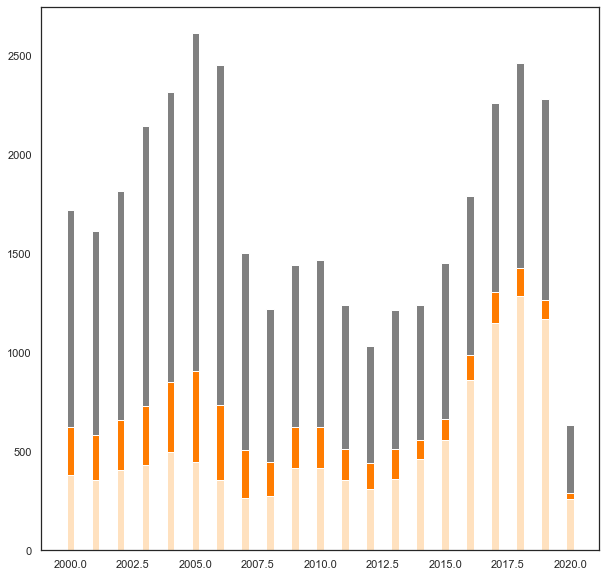

In [63]:
total_bar = total.reset_index()
f, (ax1) = plt.subplots(1,1,figsize=(10, 10))
sns.set(style="white")

plt.bar(data=total_bar,x='year', 
            height='count_field',label='total purchases', color = 'grey',width=.3)
plt.bar(data=total_bar, x='year',
            height='investor_all',label='investor purchases', color = '#FF7C00', width=.3)
plt.bar(data=total_bar, x='year',
            height='inv',label='investor purchases', color = '#FFE1BF', width=.3)
plt.savefig('exports/summary_total_purchases.svg')

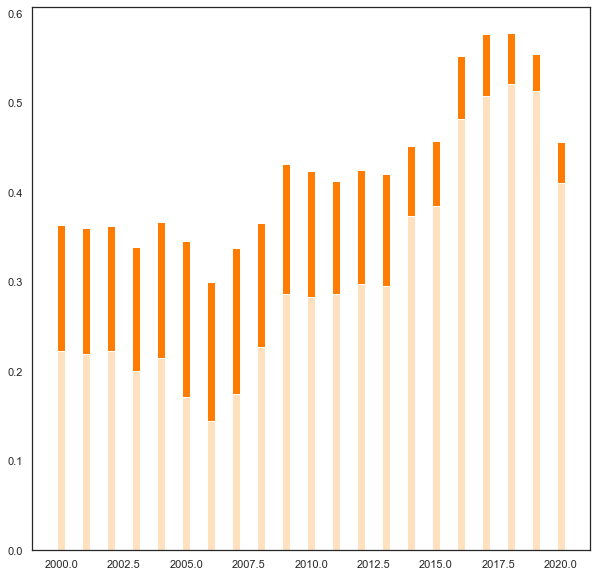

In [62]:
total_bar = total.reset_index()
f, (ax1) = plt.subplots(1,1,figsize=(10, 10))
sns.set(style="white")

# plt.bar(data=total_bar,x='year', 
#             height='inv_per',label='total purchases', color = 'grey',width=.3)
plt.bar(data=total_bar, x='year',
            height='inv_per',label='investor purchases', color = '#FF7C00', width=.3)

plt.bar(data=total_bar, x='year',
            height='inv_per_LLC',label='investor purchases', color = '#FFE1BF', width=.3)
plt.savefig('exports/summary_percent_purchases.svg')